# HY-2B SCA L2A后向散射系数投影

In [112]:
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from skimage import exposure
from RSData import *
from HaiYangData import *

import h5py
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import io
import cv2

In [114]:
def split_file_day(files):
    # 按照天来划分文件，同一天的内容在一个list里面
    file_list = []
    list = []
    for i in range(len(files)):

        if i == 0:
            list.append(files[i])
            continue

        if (files[i].split('_')[8].split('T')[0]) == (files[i-1].split('_')[8].split('T')[0]):
            list.append(files[i])
        else:
            file_list.append(list)
            list = []
            list.append(files[i])
    file_list.append(list)
    return file_list

In [122]:
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img



In [123]:
 def draw_sigmod_0(x_map, y_map, grid_array):
    fig = plt.figure(figsize=(9, 9))
    fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

    # hy_m.fillcontinents()
    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
    # you can get a high-resolution image as numpy array!!

    return fig


In [122]:
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img



In [123]:
 def draw_sigmod_0(x_map, y_map, grid_array):
    fig = plt.figure(figsize=(9, 9))
    fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

    # hy_m.fillcontinents()
    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
    # you can get a high-resolution image as numpy array!!

    return fig


In [113]:
satellite = r'HY2B'
sensor = r'SCA'
hy_sca = HaiYangData(satellite=satellite, sensor=sensor,resolution=25000)

# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

dir_path = r"H:\remote_sensing_data\back_scatter\HY-2B"

files = glob.glob(dir_path + '\*_pwp_250_03.h5')

file_list = split_file_day(files)

In [116]:
transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

<ipython-input-131-0227ce00ad39>:30: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-123-15a1d73dabe3>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
<ipython-input-131-0227ce00ad39>:30: RuntimeWarning: invalid value encountered in true_divide
  grid_array = grid_array / grid_num_array
<ipython-input-123-15a1d73dabe3>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['

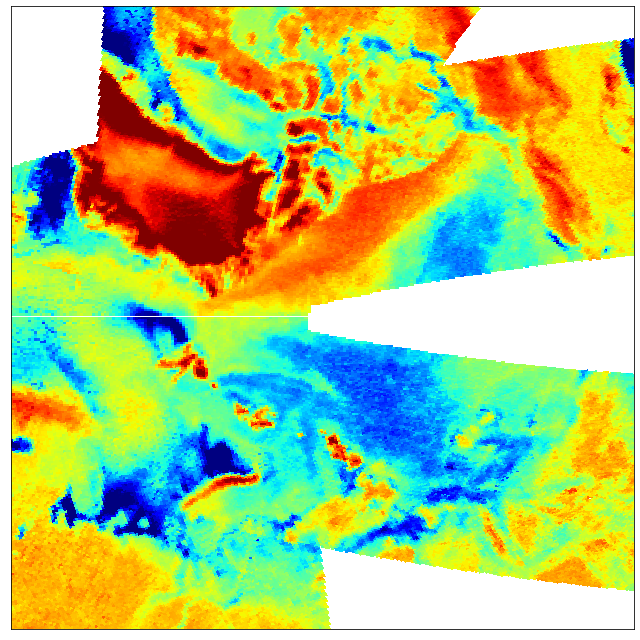

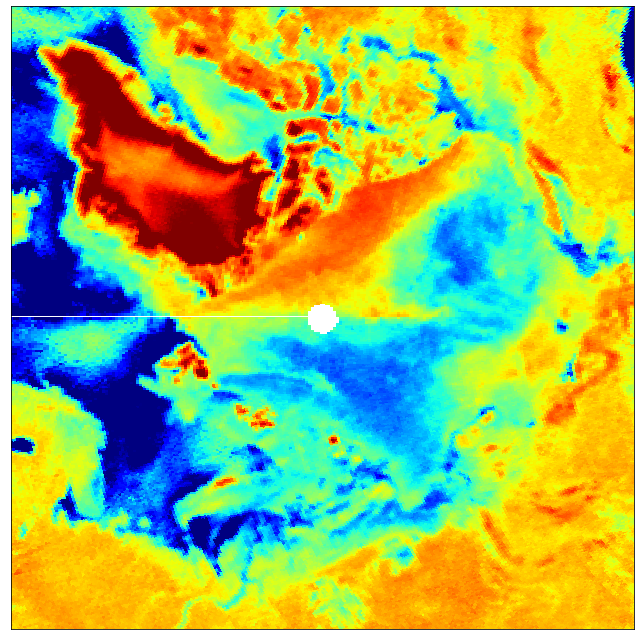

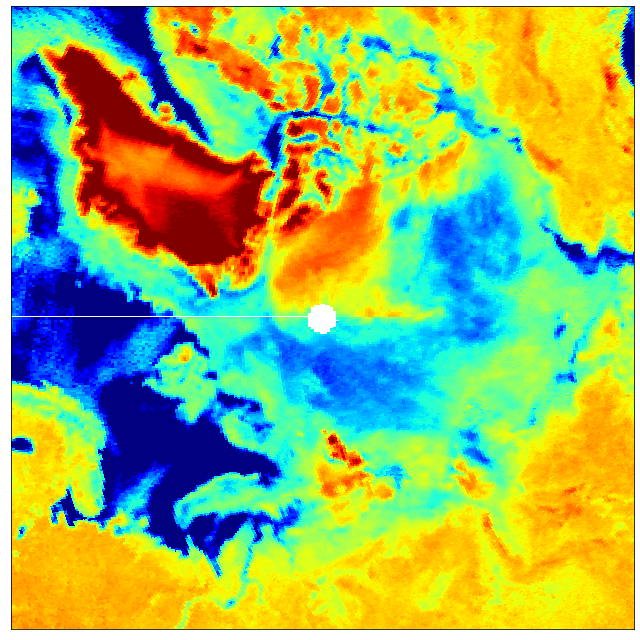

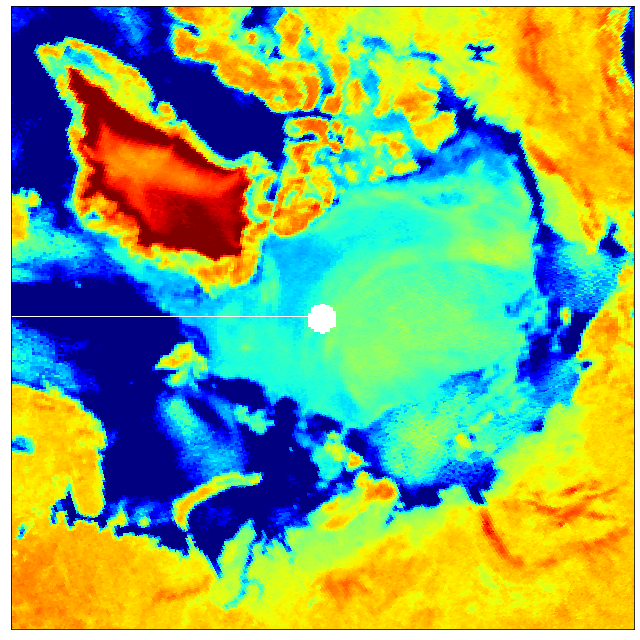

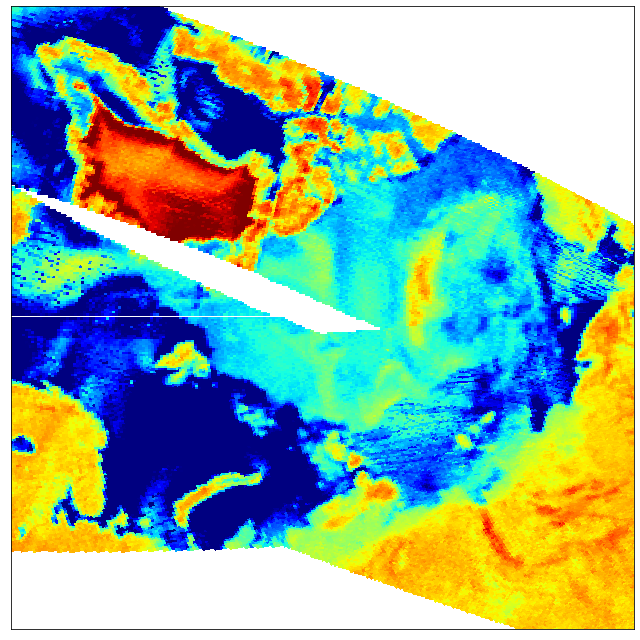

In [131]:
for files in file_list[::7]:
    value_array = np.empty(shape=(1702, 810,5))
    grid_array = np.zeros((hy_sca.nlat, hy_sca.nlon))
    grid_num_array = np.zeros((hy_sca.nlat, hy_sca.nlon))

    for file in files:
        with h5py.File(file, mode='r') as f:
            lat = f['cell_lat'][:]
            lon = f['cell_lon'][:]
            sigma0 = f['cell_sigma0'][:]

        sigma0 = sigma0*0.01

        lat[lat > 90] = 0 
        lon[lon > 360] = 0 
        sigma0[sigma0 < -300] = 0
        projlats, projlons = transformer.transform(lat, lon)

        value_array[:,:,0] = lat
        value_array[:,:,1] = lon
        value_array[:,:,2],value_array[:,:,3] = transformer.transform(value_array[:,:,0], value_array[:,:,1])
        value_array[:,:,4] = sigma0
    #     value_array[:,:,4][value_array[:,:,4] < -300] = np.nan

        x = (value_array[:,:,2] / hy_sca.resolution).astype(np.int)
        y = (value_array[:,:,3] / hy_sca.resolution).astype(np.int)
        grid_array[y,x] += value_array[:,:,4]
        grid_num_array[y,x] += 1
        
    grid_array = grid_array / grid_num_array
    x_map, y_map = hy_sca.get_map_grid(transformer_back)

    fig = draw_sigmod_0(x_map, y_map, grid_array)
    plot_img_np = get_img_from_fig(fig)

    name = files[0].split('_')[8].split('T')[0]

    np.savez((r'.\\npy\\sigmod0_'+ str(name) + '.npz'), plot_img_np)
    

fig = plt.figure(figsize=(12.5, 12.5))
fig.add_subplot(111)
fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

hy_m.fillcontinents()
hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
# hy_m.colorbar(location='right')

# hy_m.drawcoastlines(color='black')
# hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
# hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
# plt.show()
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [122]:
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img



In [123]:
 def draw_sigmod_0(x_map, y_map, grid_array):
    fig = plt.figure(figsize=(9, 9))
    fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

    # hy_m.fillcontinents()
    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)
    # you can get a high-resolution image as numpy array!!

    return fig


<ipython-input-123-15a1d73dabe3>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmax = -5,vmin=-25,latlon = True)


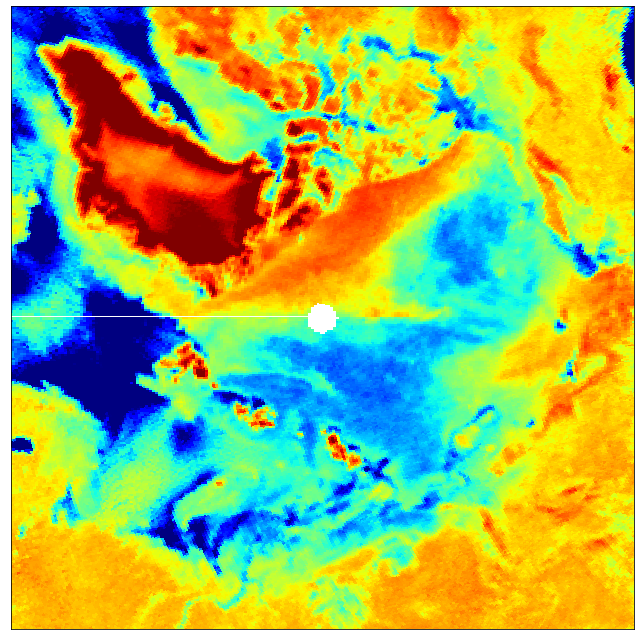

In [124]:
fig = draw_sigmod_0(x_map, y_map, grid_array)
plot_img_np = get_img_from_fig(fig)

name = files[6].split('_')[8].split('T')[0]

np.savez((r'.\\npy\\sigmod0_'+ str(name) + '.npz'), plot_img_np)


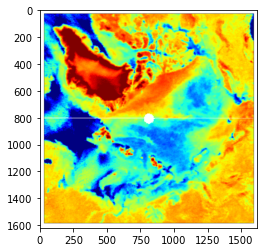

In [125]:
plt.imshow(plot_img_np)